In [12]:
import sys
import os

# Get the project root (one level above notebooks/)
project_root = os.path.abspath("..")
sys.path.append(project_root)

print("Added to Python path:", project_root)

import h5py
import numpy as np
import pandas as pd
# from src.parameters.tail_features import compute_LQ80


Added to Python path: c:\Users\YooNi\OneDrive\Desktop\Majorana-Neutrino-Hunt


In [13]:
# def compute_HWP(waveform):
#     y = np.asarray(waveform, dtype=float)

#     peak_val = float(np.max(y))
#     if peak_val <= 0:
#         return np.nan

#     level25 = 0.25 * peak_val
#     level75 = 0.75 * peak_val

#     above_25 = np.where(y >= level25)[0]
#     above_75 = np.where(y >= level75)[0]

#     if len(above_25) == 0 or len(above_75) == 0:
#         return np.nan

#     left_idx = int(above_25[0])
#     right_idx = int(above_75[-1])

#     width = right_idx - left_idx
#     if width < 0:
#         return np.nan

#     return float(width)


In [14]:
def compute_HWP(waveform, n_pre=200):
    y = np.asarray(waveform, dtype=float)

    baseline = float(np.mean(y[:n_pre]))
    y_rel = y - baseline   # shift waveform so baseline = 0

    peak_val = float(np.max(y_rel))
    if peak_val <= 0:
        return np.nan

    level25 = 0.25 * peak_val
    level75 = 0.75 * peak_val

    above_25 = np.where(y_rel >= level25)[0]
    above_75 = np.where(y_rel >= level75)[0]

    if len(above_25) == 0 or len(above_75) == 0:
        return np.nan

    left_idx = int(above_25[0])
    right_idx = int(above_75[-1])

    width = right_idx - left_idx
    if width < 0:
        return np.nan

    return float(width)


In [15]:
OUTPUT_DIR = "finalcsveunice"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [16]:
all_ids = []
all_HWP = []

for train_idx in range(16):
    train_file = f"../data/old/MJD_Train_{train_idx}.hdf5"
    if not os.path.exists(train_file):
        print(f"Skipping missing file: {train_file}")
        continue

    with h5py.File(train_file, "r") as f:
        waveforms = np.array(f["raw_waveform"])
        ids = np.array(f["id"])

    print(f"Loaded Train_{train_idx}: {len(waveforms)} waveforms")

    for i, wf in enumerate(waveforms):
        if i % 5000 == 0:
            print(f"  Train_{train_idx} processing {i}/{len(waveforms)}")

        all_HWP.append(compute_HWP(wf))
        all_ids.append(f"{ids[i]}_train_{train_idx}")

all_HWP = np.array(all_HWP, dtype=float)


df_hwp = pd.DataFrame({
    "id": all_ids,
    "HWP": all_HWP
})

output_path_hwp = os.path.join(OUTPUT_DIR, "HWP_train_all.csv")
df_hwp.to_csv(output_path_hwp, index=False)

print("\nSaved combined HWP CSV to:", output_path_hwp)
print(df_hwp.head())
print(df_hwp["HWP"].describe())
print("NaNs:", df_hwp["HWP"].isna().sum())



Loaded Train_0: 65000 waveforms
  Train_0 processing 0/65000
  Train_0 processing 5000/65000
  Train_0 processing 10000/65000
  Train_0 processing 15000/65000
  Train_0 processing 20000/65000
  Train_0 processing 25000/65000
  Train_0 processing 30000/65000
  Train_0 processing 35000/65000
  Train_0 processing 40000/65000
  Train_0 processing 45000/65000
  Train_0 processing 50000/65000
  Train_0 processing 55000/65000
  Train_0 processing 60000/65000
Loaded Train_1: 65000 waveforms
  Train_1 processing 0/65000
  Train_1 processing 5000/65000
  Train_1 processing 10000/65000
  Train_1 processing 15000/65000
  Train_1 processing 20000/65000
  Train_1 processing 25000/65000
  Train_1 processing 30000/65000
  Train_1 processing 35000/65000
  Train_1 processing 40000/65000
  Train_1 processing 45000/65000
  Train_1 processing 50000/65000
  Train_1 processing 55000/65000
  Train_1 processing 60000/65000
Loaded Train_2: 65000 waveforms
  Train_2 processing 0/65000
  Train_2 processing 5000/6

In [17]:
nan_rows = df_hwp[df_hwp["HWP"].isna()]

print("Number of NaNs:", len(nan_rows))
nan_rows.head(10)


Number of NaNs:

 0


,id,HWP


In [18]:
nan_rows["train_idx"] = nan_rows["id"].str.extract(r"_train_(\d+)").astype(int)

nan_rows["train_idx"].value_counts()


Series([], Name: count, dtype: int64)


Tag: 253720_train_3
File: ../data/old/MJD_Train_3.hdf5
peak_val: -22.0
Reason: peak_val <= 0 (flat or negative waveform).


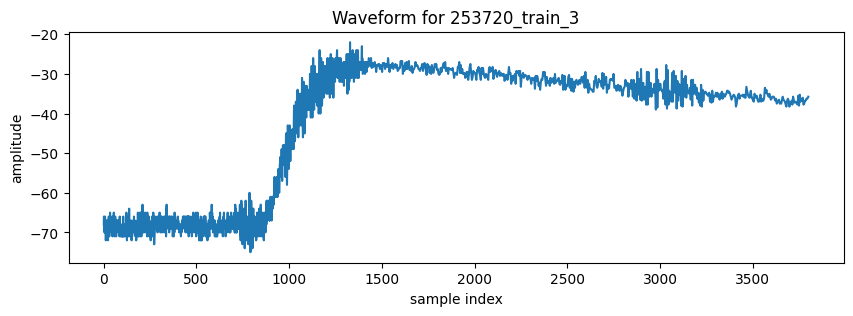


Tag: 391741_train_6
File: ../data/old/MJD_Train_6.hdf5
peak_val: -13.0
Reason: peak_val <= 0 (flat or negative waveform).


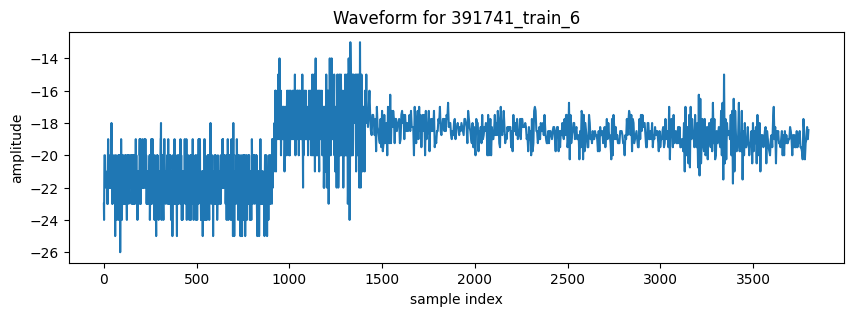


Tag: 524458_train_8
File: ../data/old/MJD_Train_8.hdf5
peak_val: -2.0
Reason: peak_val <= 0 (flat or negative waveform).


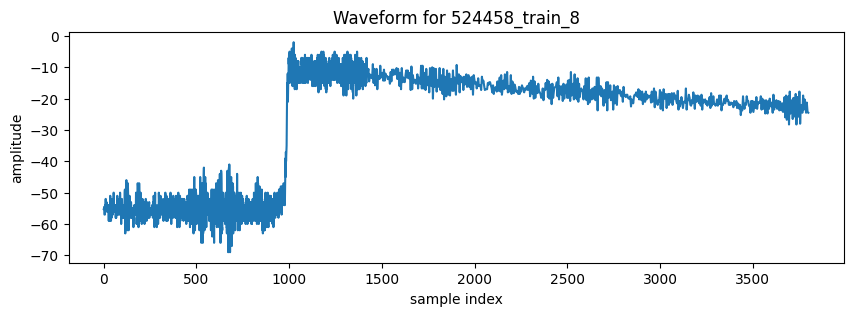


Tag: 586359_train_9
File: ../data/old/MJD_Train_9.hdf5
peak_val: -14.0
Reason: peak_val <= 0 (flat or negative waveform).


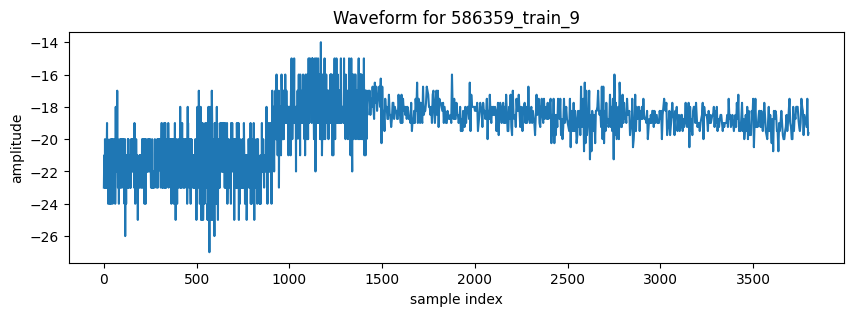


Tag: 845815_train_13
File: ../data/old/MJD_Train_13.hdf5
peak_val: -12.0
Reason: peak_val <= 0 (flat or negative waveform).


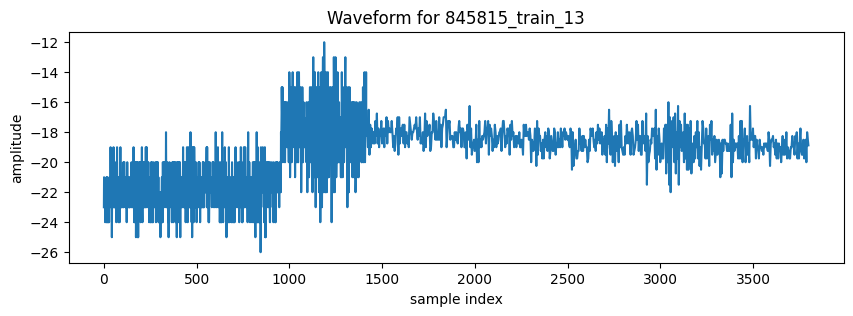

In [19]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

bad_ids = [
    "253720_train_3",
    "391741_train_6",
    "524458_train_8",
    "586359_train_9",
    "845815_train_13",
]

def inspect_hwp_nan(tag):
    base_id_str, train_idx_str = tag.split("_train_")
    base_id = int(base_id_str)
    train_idx = int(train_idx_str)

    path = f"../data/old/MJD_Train_{train_idx}.hdf5"
    print("\n==============================")
    print("Tag:", tag)
    print("File:", path)

    with h5py.File(path, "r") as f:
        ids_local = np.array(f["id"])
        hits = np.where(ids_local == base_id)[0]
        if len(hits) == 0:
            print("Could not find id inside this file.")
            return
        j = int(hits[0])
        wf = np.array(f["raw_waveform"][j], dtype=float)

    # Check for non-finite
    if not np.all(np.isfinite(wf)):
        print("Reason: waveform contains NaN/inf values.")
    else:
        peak_val = float(np.max(wf))
        print("peak_val:", peak_val)

        if peak_val <= 0:
            print("Reason: peak_val <= 0 (flat or negative waveform).")
        else:
            level25 = 0.25 * peak_val
            level75 = 0.75 * peak_val
            above_25 = np.where(wf >= level25)[0]
            above_75 = np.where(wf >= level75)[0]

            print("crosses 25%:", len(above_25) > 0, "count:", len(above_25))
            print("crosses 75%:", len(above_75) > 0, "count:", len(above_75))

            if len(above_25) == 0 or len(above_75) == 0:
                print("Reason: never crosses 25% or 75% threshold.")
            else:
                left_idx = int(above_25[0])
                right_idx = int(above_75[-1])
                width = right_idx - left_idx
                print("left_idx:", left_idx, "right_idx:", right_idx, "width:", width)

                if width < 0:
                    print("Reason: width < 0 (unexpected ordering).")
                else:
                    print("If computed, HWP would be:", float(width))

    # Plot waveform
    plt.figure(figsize=(10, 3))
    plt.plot(wf)
    plt.title(f"Waveform for {tag}")
    plt.xlabel("sample index")
    plt.ylabel("amplitude")
    plt.show()

for tag in bad_ids:
    inspect_hwp_nan(tag)


In [20]:
# test file 
all_test_ids = []
all_test_HWP = []

for test_idx in range(6):
    test_file = f"../data/old/MJD_Test_{test_idx}.hdf5"
    if not os.path.exists(test_file):
        print(f"Skipping missing file: {test_file}")
        continue

    with h5py.File(test_file, "r") as f:
        waveforms = np.array(f["raw_waveform"])
        ids = np.array(f["id"])

    print(f"Loaded Test_{test_idx}: {len(waveforms)} waveforms")

    for i, wf in enumerate(waveforms):
        if i % 5000 == 0:
            print(f"  Test_{test_idx} processing {i}/{len(waveforms)}")

        all_test_HWP.append(compute_HWP(wf))
        all_test_ids.append(f"{ids[i]}_test_{test_idx}")

all_test_HWP = np.array(all_test_HWP, dtype=float)
all_test_HWP[~np.isfinite(all_test_HWP)] = np.nan

df_hwp_test = pd.DataFrame({
    "id": all_test_ids,
    "HWP": all_test_HWP
})

output_path_hwp_test = os.path.join(OUTPUT_DIR, "HWP_test_all.csv")
df_hwp_test.to_csv(output_path_hwp_test, index=False)

print("\nSaved combined HWP TEST CSV to:", output_path_hwp_test)
print(df_hwp_test.head())
print(df_hwp_test["HWP"].describe())
print("NaNs:", df_hwp_test["HWP"].isna().sum())


Loaded Test_0: 65000 waveforms
  Test_0 processing 0/65000
  Test_0 processing 5000/65000
  Test_0 processing 10000/65000
  Test_0 processing 15000/65000
  Test_0 processing 20000/65000
  Test_0 processing 25000/65000
  Test_0 processing 30000/65000
  Test_0 processing 35000/65000
  Test_0 processing 40000/65000
  Test_0 processing 45000/65000
  Test_0 processing 50000/65000
  Test_0 processing 55000/65000
  Test_0 processing 60000/65000
Loaded Test_1: 65000 waveforms
  Test_1 processing 0/65000
  Test_1 processing 5000/65000
  Test_1 processing 10000/65000
  Test_1 processing 15000/65000
  Test_1 processing 20000/65000
  Test_1 processing 25000/65000
  Test_1 processing 30000/65000
  Test_1 processing 35000/65000
  Test_1 processing 40000/65000
  Test_1 processing 45000/65000
  Test_1 processing 50000/65000
  Test_1 processing 55000/65000
  Test_1 processing 60000/65000
Loaded Test_2: 65000 waveforms
  Test_2 processing 0/65000
  Test_2 processing 5000/65000
  Test_2 processing 10000/